<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Monument-to-All-Your-Data" data-toc-modified-id="A-Monument-to-All-Your-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A Monument to All Your Data</a></span><ul class="toc-item"><li><span><a href="#Preprocess-the-dataset" data-toc-modified-id="Preprocess-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocess the dataset</a></span><ul class="toc-item"><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Word2Vec</a></span></li></ul></li><li><span><a href="#Tokenize" data-toc-modified-id="Tokenize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tokenize</a></span></li><li><span><a href="#Label-Encoder" data-toc-modified-id="Label-Encoder-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Label Encoder</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Dummy-Predictor-(Baseline)" data-toc-modified-id="Dummy-Predictor-(Baseline)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dummy Predictor (Baseline)</a></span></li></ul></div>

# A Monument to All Your Data

If you choose this option, you'll build an NLP model to analyze Twitter sentiment about Apple and Google products. The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["text", "directed_at", "target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
UNSURE = "UNSURE"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omarhussain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#Create Dataframe
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding=DATASET_ENCODING, names = DATASET_COLUMNS)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9094 entries, 0 to 9093
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         9093 non-null   object
 1   directed_at  3292 non-null   object
 2   target       9094 non-null   object
dtypes: object(3)
memory usage: 213.3+ KB


In [6]:
# Check how many null values there are
df.isnull().sum()

text              1
directed_at    5802
target            0
dtype: int64

In [7]:
#Check target Variables
df['target'].unique()

array(['is_there_an_emotion_directed_at_a_brand_or_product',
       'Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [8]:
df.drop(index=0, inplace= True)

In [9]:
replace_map = {'Negative emotion': "NEGATIVE", 
              'No emotion toward brand or product': "NEUTRAL",
              "I can't tell": "UNSURE", 
              'Positive emotion': "POSITIVE"}


In [10]:
df.replace(replace_map, inplace = True)

In [11]:
df.head()

,text,directed_at,target
1,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,NEGATIVE
2,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,POSITIVE
3,@swonderlin Can not wait for #iPad 2 also. The...,iPad,POSITIVE
4,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,NEGATIVE
5,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,POSITIVE


Text(0.5, 1.0, 'Dataset labels distribuition')

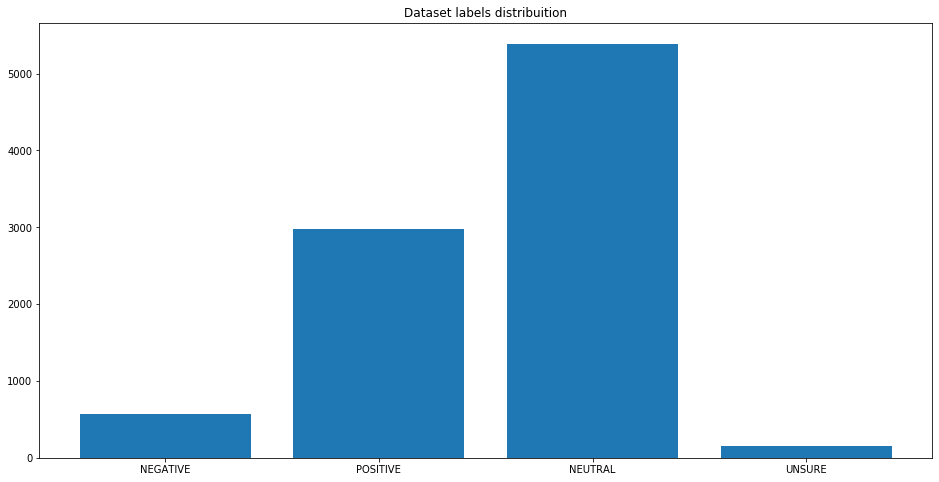

In [12]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Preprocess the dataset

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 424 ms, sys: 4.68 ms, total: 428 ms
Wall time: 431 ms


Divide the data

In [16]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 7274
TEST size: 1819


### Word2Vec

Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

In [17]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 10.4 ms, sys: 2.12 ms, total: 12.5 ms
Wall time: 12.2 ms


In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=16)

In [19]:
w2v_model.build_vocab(documents)

In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1073


In [21]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 5.2 s, sys: 124 ms, total: 5.33 s
Wall time: 2.23 s


(1444250, 2900224)

In [44]:
w2v_model.most_similar("sxsw")

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('went', 0.33887192606925964),
 ('goes', 0.3337230384349823),
 ('mention', 0.33024531602859497),
 ('shit', 0.3277202546596527),
 ('rt', 0.3148581087589264),
 ('real', 0.31482428312301636),
 ('south', 0.3059775233268738),
 ('everywhere', 0.30249500274658203),
 ('media', 0.29383614659309387),
 ('review', 0.2897334694862366)]

## Tokenize

In [23]:
%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
Total words 8624


In [24]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 224 ms, sys: 9.7 ms, total: 233 ms
Wall time: 244 ms


## Label Encoder

In [25]:
labels = df_train.target.unique().tolist()
labels

['NEUTRAL', 'POSITIVE', 'NEGATIVE', 'UNSURE']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (7274, 1)
y_test (1819, 1)


# EDA

In [28]:
df.head()

,text,directed_at,target
1,wesley83 3g iphone 3 hrs tweeting rise austin ...,iPhone,NEGATIVE
2,know fludapp awesome ipad iphone app likely ap...,iPad or iPhone App,POSITIVE
3,wait ipad 2 also sale sxsw,iPad,POSITIVE
4,hope year festival crashy year iphone app sxsw,iPad or iPhone App,NEGATIVE
5,great stuff fri sxsw marissa mayer google tim ...,Google,POSITIVE


In [33]:
from wordcloud import WordCloud, STOPWORDS
df['text'] = df['text'].fillna("").astype('str')
title_corpus = ' '.join(df['text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

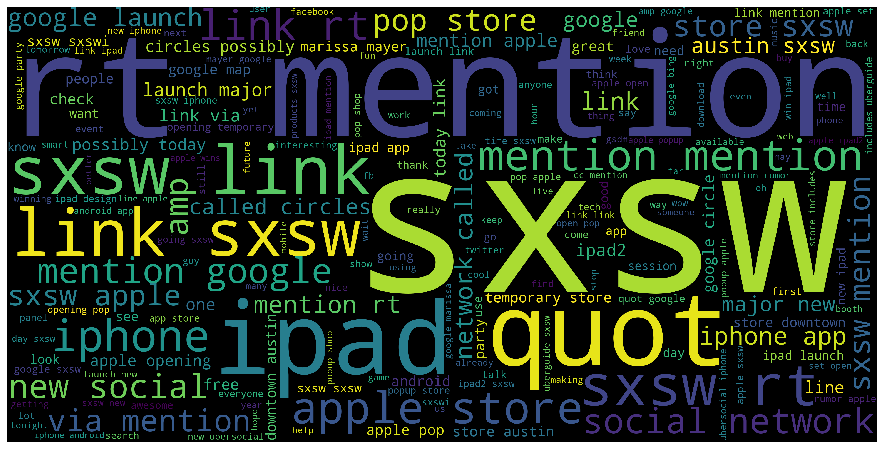

In [34]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

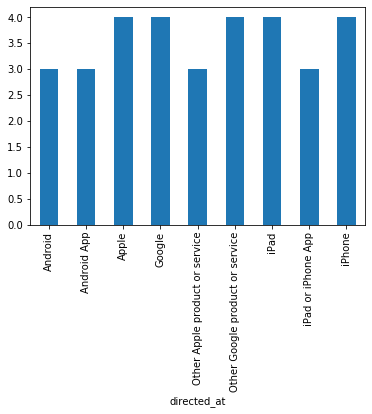

In [38]:
df.groupby('directed_at')['target'].nunique().plot(kind='bar')

In [42]:
df.directed_at.replace({'Android App': 'Android', 
                       'Other Apple product or service': 'Apple',
                      'Other Google product or service': 'Google',
                      'iPad': 'Apple',
                      'iPad or iPhone App': 'Apple',
                      'iPhone': 'Apple'}, inplace=True)

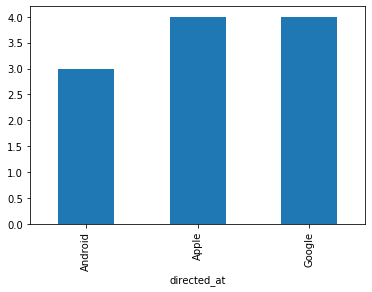

In [43]:
df.groupby('directed_at')['target'].nunique().plot(kind='bar')

# Dummy Predictor (Baseline)

In [35]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

dummy = DummyClassifier(strategy='stratified').fit(x_train, y_train)
dummy_pred = dummy.predict(x_test)

In [36]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred, ))

# checking recall
print('Test Recall score: ', recall_score(y_test, dummy_pred, average='weighted'))

#Checking F1
print('Test F1 score: ', f1_score(y_test, dummy_pred, average='weighted'))

Test Accuracy score:  0.4480483782297966
Test Recall score:  0.4480483782297966
Test F1 score:  0.4495579622733449
